## Checking the backward phase

In [1]:
import numpy as np
import sempler
import sempler.generators
import sempler.utils
import matplotlib.pyplot as plt
import pandas as pd

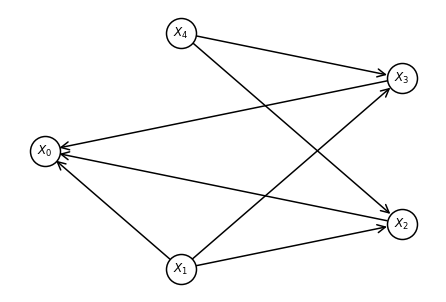

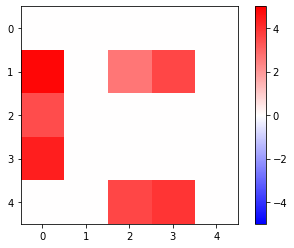

In [2]:
np.random.seed(1)
true_A = np.array([[0,0,1,0,0],
                 [0,0,1,0,0],
                 [0,0,0,1,1],
                 [0,0,0,0,1],
                 [0,0,0,0,0]])
p = len(true_A)
p = 5
true_A = sempler.generators.dag_avg_deg(p, 2.1)

sempler.utils.plot_graph(true_A)
W = true_A * np.random.uniform(2,5,size=true_A.shape)

scm = sempler.LGANM(W, (0,0), (1,2))
plt.imshow(W, vmin=-5, vmax=5, cmap='bwr')
plt.colorbar()

In [3]:
#np.random.seed(12)
n = 1000
XX = [scm.sample(n)]

interventions = [{0: (0, 10)}
                 ,{1: (0, 10)}
                 #,{2: (0, 10)}
                 #,{3: (0, 10)}
                 ,{4: (10, 10)}
                ]

for i in interventions:
    XX.append(scm.sample(n, shift_interventions=i))

print("Data from %d environments" % len(XX))

sample_covariances = np.array([np.cov(env, rowvar=False, ddof=0) for env in XX])
n_obs = np.array([len(env) for env in XX])

Data from 4 environments


### Write the data into a CSV

In [4]:
flattened = []
for e,X in enumerate(XX):
    flagged = np.hstack([np.ones((len(X),1)) * e, X])
    flattened.append(flagged)
flattened = np.vstack(flattened)
flattened

array([[ 0.00000000e+00,  1.00404814e-01,  3.07950322e-01,
        -1.87591646e-01, -9.69058661e-02, -3.97843681e-01],
       [ 0.00000000e+00, -3.14172929e+01, -1.49860225e+00,
        -2.95765992e+00, -3.48677149e+00,  4.30918712e-01],
       [ 0.00000000e+00, -1.40215016e+01, -3.45406464e-02,
        -3.61271015e+00, -5.97881453e-01, -8.65204754e-01],
       ...,
       [ 3.00000000e+00,  1.50856100e+02, -4.97611065e-01,
         2.05500092e+01,  1.87670045e+01,  5.56443037e+00],
       [ 3.00000000e+00,  2.80295941e+02,  9.28300713e-02,
         3.28109569e+01,  3.80458993e+01,  9.04231092e+00],
       [ 3.00000000e+00,  1.29190744e+02, -1.10049205e+00,
         1.61616532e+01,  1.75973429e+01,  5.66640807e+00]])

In [5]:
path = 'data/test_data.csv'
df = pd.DataFrame(flattened)
df.to_csv(path, header=False, index=False)

In [6]:
pd.read_csv(path, header=None)

,0,1,2,3,4,5
0,0.0,0.100405,0.307950,-0.187592,-0.096906,-0.397844
1,0.0,-31.417293,-1.498602,-2.957660,-3.486771,0.430919
2,0.0,-14.021502,-0.034541,-3.612710,-0.597881,-0.865205
3,0.0,13.282081,-0.470514,0.938310,2.687562,0.700558
4,0.0,42.368640,0.559062,5.915935,4.085491,0.620964
...,...,...,...,...,...,...
3995,3.0,278.977009,-0.695752,33.948133,36.969588,9.719226
3996,3.0,8.135774,-2.926308,3.060126,3.220389,3.003630
3997,3.0,150.856100,-0.497611,20.550009,18.767005,5.564430
3998,3.0,280.295941,0.092830,32.810957,38.045899,9.042311


### Test ICP

In [7]:
import causalicp as icp

In [8]:
%%time
target = 2
result = icp.fit(XX, target, alpha=0.001, verbose=True)

Tested sets and their p-values
  set() rejected - (p=0.0000)
  {0} rejected - (p=0.0000)
  {1} rejected - (p=0.0000)
  {3} rejected - (p=0.0000)
  {4} rejected - (p=0.0000)
  {0, 1} accepted - (p=0.0017)
  {0, 3} rejected - (p=0.0000)
  {0, 4} accepted - (p=0.1577)
  {1, 3} accepted - (p=0.0090)
  {1, 4} accepted - (p=1.3654)
  {3, 4} accepted - (p=4.7547)
  {0, 1, 3} rejected - (p=0.0000)
  {0, 1, 4} accepted - (p=0.4661)
  {0, 3, 4} rejected - (p=0.0000)
  {1, 3, 4} accepted - (p=1.3638)
  {0, 1, 3, 4} rejected - (p=0.0000)

Estimated parental set: set()

CPU times: user 270 ms, sys: 715 µs, total: 271 ms
Wall time: 40.8 ms


In [9]:
for S in result.accepted:
    adapted = []
    for s in S:
        if s > target:
            adapted.append(s)
        else:
            adapted.append(s+1)
    print(adapted)

[1, 2]
[1, 4]
[2, 3]
[2, 4]
[3, 4]
[1, 2, 4]
[2, 3, 4]


In [10]:
result.estimate

set()